In [33]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from PIL import Image
from torchvision.models import efficientnet_b3

import timm
import matplotlib.pyplot as plt

In [2]:
# --------- Classifier Head (Same as before) ---------
class COVIDNetClassifierLarge(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(COVIDNetClassifierLarge, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [3]:
# --------- Preprocessing (match training) ---------
def get_transform():
    return transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])

In [34]:
# --------- Predict on a Single Image ---------
def predict_image(image_path, model, backbone, class_names, labels_csv=None):
    # Load image
    image = Image.open(image_path).convert('RGB')
    image = np.array(image) / 255.0       # [0, 1]
    image = Image.fromarray((image * 255).astype(np.uint8))            # back to [0, 255]

    transform = get_transform()
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Extract features using EfficientNet (without classifier)
    with torch.no_grad():
        backbone.eval()
        features = backbone(input_tensor)
        #pooled_features = nn.functional.adaptive_avg_pool2d(features, 1).squeeze()  # (1280,)
        features_flat = features.view(1, -1)  # (1, 1280)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(features_flat.to(device))
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    # Get true label if CSV provided
    true_label = None
    if labels_csv is not None:
        df = pd.read_csv(labels_csv, header=None, names=['image', 'label'])
        img_name = os.path.basename(image_path)
        row = df[df['image'] == img_name]
        if not row.empty:
            true_label = int(row.iloc[0]['label'])
            true_label = class_names[true_label]

    plt.imshow(image)
    plt.title(f"{os.path.basename(image_path)}\nPredicted: {class_names[pred]} ({probs[0][pred]*100:.2f}%)")
    plt.axis('off')
    plt.show()
    
    # Display
    print(f"\n📸 Image: {os.path.basename(image_path)}")
    print(f"✅ Predicted: {class_names[pred]} (with probability: {probs[0][pred]*100:.2f}%)")
    if true_label is not None:
        print(f"🎯 Actual:    {true_label}")

C:\Users\Safi\AppData\Local\Temp\ipykernel_16588\386269991.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

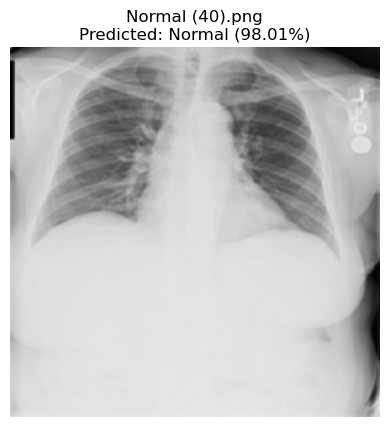


📸 Image: Normal (40).png
✅ Predicted: Normal (with probability: 98.01%)
🎯 Actual:    Normal


In [35]:
# --------- Main ---------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set paths
    image_path = "efficientnet_dataset/test/Normal (40).png"
    labels_csv = "efficientnet_dataset/test/test_mapping.csv"          # CSV with columns: image,label
    model_path = "efficientnet_covidnet.pt"

    # Setup
    num_classes = 3
    class_names = ['COVID-19', 'Non-COVID', 'Normal'] # Since we used class mapping 'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2
    
    # Load EfficientNet backbone
    #backbone = efficientnet_b3(pretrained=True).to(device)
    backbone = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0).to(device)
    
    # Load Classifier Head
    input_dim = 1536  # EfficientNet-B3 output
    model = COVIDNetClassifierLarge(input_dim=input_dim, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)

    # Run prediction
    predict_image(image_path, model, backbone, class_names, labels_csv)